![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)

# Recommendation Systems: Two Tower Deep Learning Models with RedisVL

<a href="https://colab.research.google.com/github/redis-developer/redis-ai-resources/blob/main/python-recipes/recomendation-systems/02_two_towers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recommendation systems are a common application of machine learning and serve many industries from e-commerce to music streaming platforms.

There are many different architectures that can be followed to build a recommendation system. In previous example notebooks we demonstrated two common approaches that leverage different methods. Our first showed how to do [content filtering with RedisVL](content_filtering.ipynb) where an item's underlying features determine what gets recommended.
Next, we showcased how RedisVL can be used to build a [collaborative filtering recommender](collaborative_filtering.ipynb), which leverages users' ratings of items to create personalized recommendations. Before continuing with this notebook we encourage you to start with the previous two.

In this notebook we'll demonstrate how to build a [two tower recommendation system](https://cloud.google.com/blog/products/ai-machine-learning/scaling-deep-retrieval-tensorflow-two-towers-architecture)
and compare it to architectures we've seen before.

Let's begin!

To mix things up a bit, instead of using our movies dataset like the previous two examples, we'll look at brick & mortar restaurants in San Francisco as our items to recommend.

In [1]:
import os
import requests
import pandas as pd
import json

# Replace values below with your own if using Redis Cloud instance
REDIS_HOST = os.getenv("REDIS_HOST", "localhost") # ex: "redis-18374.c253.us-central1-1.gce.cloud.redislabs.com"
REDIS_PORT = os.getenv("REDIS_PORT", "6379")      # ex: 18374
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "")  # ex: "1TNxTEdYRDgIDKM2gDfasupCADXXXX"

# If SSL is enabled on the endpoint, use rediss:// as the URL prefix
REDIS_URL = f"redis://:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}"

In [2]:
def fetch_data(file_name):
    try:
        df = pd.read_csv('datasets/two-towers/' + file_name)
    except:
        url = 'https://redis-ai-resources.s3.us-east-2.amazonaws.com/recommenders/datasets/two-towers/'
        r = requests.get(url + file_name)
        if not os.path.exists('datasets/two-towers'):
            os.makedirs('datasets/two_towers')
        with open('datasets/two-towers/' + file_name, 'wb') as f:
            f.write(r.content)
        df = pd.read_csv('datasets/two_towers/' + file_name)
    return df

In [3]:
# the original dataset an be found here: https://www.kaggle.com/datasets/jkgatt/restaurant-data-with-100-trip-advisor-reviews-each
with open('./datasets/two_towers/factual_tripadvisor_restaurant_data_all_100_reviews.json', 'r') as f:
    restaurant_data = json.load(f)

print(f"we have {restaurant_data['restaurant_count']} restaurants in our dataset, with {restaurant_data['total_review_count']} total reviews")

restaurant_data = restaurant_data["restaurants"] # ignore the count fields

we have 147 restaurants in our dataset, with 14700 total reviews


In [4]:

df = pd.DataFrame(restaurant_data)

df.fillna('', inplace=True)

df.drop(columns=['region', 'country', 'tel','fax', 'email', 'website', 'address_extended', 'chain_name','trip_advisor_url'], inplace=True)
df['unique_name'] = df['name'] +' ' + df['address'] # some restaurants are chains or have more than one location
df.head()


,name,address,locality,latitude,longitude,cuisine,price,rating,hours,parking,...,meal_takeout,meal_cater,options_healthy,options_organic,options_vegetarian,options_vegan,options_glutenfree,options_lowfat,reviews,unique_name
0,21st Amendment Brewery & Restaurant,563 2nd St,San Francisco,37.782448,-122.392576,"[Cafe, Pub Food, American, Burgers, Pizza]",2,4.0,"{'monday': [['11:30', '23:59']], 'tuesday': [[...",True,...,True,False,True,False,True,False,False,False,"[{'review_website': 'TripAdvisor', 'review_url...",21st Amendment Brewery & Restaurant 563 2nd St
1,Absinthe Brasserie & Bar,398 Hayes St,San Francisco,37.777083,-122.422882,"[French, Californian, Mediterranean, Cafe, Ame...",3,4.0,"{'tuesday': [['11:30', '23:59']], 'wednesday':...",True,...,True,True,True,False,True,False,False,False,"[{'review_website': 'TripAdvisor', 'review_url...",Absinthe Brasserie & Bar 398 Hayes St
2,Amber India Restaurant,25 Yerba Buena Ln,San Francisco,37.785772,-122.404401,"[Indian, Chinese, Vegetarian, Asian, Pakistani]",2,4.5,"{'monday': [['11:30', '14:30'], ['17:00', '22:...",True,...,True,True,True,False,True,True,True,False,"[{'review_website': 'TripAdvisor', 'review_url...",Amber India Restaurant 25 Yerba Buena Ln
3,Americano,8 Mission St,San Francisco,37.793620,-122.392915,"[Italian, American, Californian, Pub Food, Cafe]",3,3.5,"{'monday': [['6:30', '10:30'], ['11:30', '14:3...",True,...,True,True,True,False,True,False,False,False,"[{'review_website': 'TripAdvisor', 'review_url...",Americano 8 Mission St
4,Anchor & Hope,83 Minna St,San Francisco,37.787848,-122.398812,"[Seafood, American, Cafe, Chowder, Californian]",3,4.0,"{'monday': [['11:30', '14:00'], ['17:30', '22:...",True,...,True,True,True,False,True,True,True,False,"[{'review_website': 'TripAdvisor', 'review_url...",Anchor & Hope 83 Minna St


If you wanted to build a content filtering system now would be a good time to extract the text from the reviews, join them together and generate semantic embeddings from them like we did in our previous notebook.

This would be a great approach, but to demonstrate the two tower architecture we won't use a pre-trained embedding model, and instead use the other columns as our raw features - but we will at least extract the numerical ratings from the reviews.


In [5]:
import numpy as np

df['min_rating'] = df['reviews'].apply(lambda x: np.min([r["review_rating"] for r in x]))
df['max_rating'] = df['reviews'].apply(lambda x: np.max([r["review_rating"] for r in x]))
df['avg_rating'] = df['reviews'].apply(lambda x: np.mean([r["review_rating"] for r in x]))
df['stddev_rating'] = df['reviews'].apply(lambda x: np.std([r["review_rating"] for r in x]))
df['price'] = df['price'].astype(int)

# now take all the features we have and build a raw feature vector for each restaurant
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
boolean_cols = df.select_dtypes(include=['bool']).columns

# convert boolean columns to integers
df[boolean_cols] = df[boolean_cols].astype(int)

# combine numerical and boolean columns into a single vector
df['feature_vector'] = df[numerical_cols.tolist() + boolean_cols.tolist()].values.tolist()

We now have feature vectors with 30 features for each restaurant. The next step is to construct our raw feature vectors for our users.

We don't have publicly available user data to correspond with this list of restaurants, so instead we'll generate some using the popular testing tool Faker.

In [6]:
#NBEVAL_SKIP
!pip install Faker --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from faker import Faker
from uuid import uuid4

fake = Faker()

def generate_user():
    return {
        "user_id": str(uuid4()),
        "name": fake.name(),
        "username": fake.user_name(),
        "email": fake.email(),
        "address": fake.address(),
        "phone_number": fake.phone_number(),
        "birthdate": fake.date_of_birth().isoformat(),
        "likes": fake.random_elements(elements=['burgers', 'shakes', 'pizza', 'italian', 'mexican', 'fine dining', 'bbq', 'cocktails', 'breweries', 'ethiopian', 'pasta', 'brunch','fast food'], unique=True),
        "account_created_on": fake.date() ,
        "price_bracket": fake.random_element(elements=("low", "middle", "high")),
        "newsletter": fake.boolean(),
        "notifications": fake.boolean(),
        "profile_visibility": fake.random_element(elements=("public", "private", "friends-only")),
        "data_sharing": fake.boolean()
    }

users = [generate_user() for _ in range(1000)]

users_df = pd.DataFrame(users)
users_df.head()

,user_id,name,username,email,address,phone_number,birthdate,likes,account_created_on,price_bracket,newsletter,notifications,profile_visibility,data_sharing
0,ff2a862f-51d1-445e-b7b6-d373a55e69e7,Robert Ritter,qbanks,jimmyfuller@example.org,"37613 Bailey Vista Suite 743\nEast April, MS 6...",(554)658-7631x4605,1995-07-08,"[ethiopian, italian]",2007-06-28,middle,True,True,friends-only,True
1,e398f3d5-8f22-478a-bb00-b8c6aac0bcc5,Kristen Cruz,halldanielle,jennadouglas@example.net,"936 Coleman Parks\nDayside, NM 51306",(980)314-2370x0348,2005-06-13,[italian],1981-07-01,low,True,False,friends-only,True
2,9bf48480-5550-4186-85d9-8fe472c53ff0,Elizabeth Robinson,howardjeremy,juan53@example.com,"01256 Perry Neck\nLongburgh, NJ 91913",(993)687-0534x1023,1957-09-30,[fast food],1972-06-01,high,False,True,public,True
3,f183691b-1089-41ac-8136-301867b55232,Kayla Burgess,michael51,cameronpollard@example.org,"4698 Sanders Brooks\nDanielmouth, NE 26230",683-206-3462,1962-08-01,"[cocktails, pasta, brunch, fast food]",2007-12-10,high,True,False,public,False
4,2e9dd0fd-7e65-4142-b552-5a5a039ea343,Tara Graham,jason22,monica86@example.com,"869 Perkins Place Suite 340\nBarbaraborough, N...",544.768.6860x239,1915-01-01,"[ethiopian, pasta, shakes, bbq, brunch, pizza,...",1971-01-02,low,True,True,public,True


In [8]:

from sklearn.preprocessing import MultiLabelBinarizer

# use a MultiLabelBinarizer to one-hot encode our user's 'likes' column, which has a list of users' food preferences
mlb = MultiLabelBinarizer()

likes_encoded = mlb.fit_transform(users_df['likes'])
likes_df = pd.DataFrame(likes_encoded, columns=mlb.classes_)

# concatenate the original users_df with the new one-hot encoded likes_df
users_df = pd.concat([users_df, likes_df], axis=1)

# one-hot encode categorical columns
categorical_cols = ['price_bracket', 'profile_visibility']
users_df = pd.get_dummies(users_df, columns=categorical_cols)

# convert boolean columns to integers
boolean_cols = users_df.select_dtypes(include=['boolean']).columns
users_df[boolean_cols] = users_df[boolean_cols].astype(int)

# combine all numerical columns into a single feature vector
numerical_cols = users_df.select_dtypes(include=['int64', 'uint8']).columns
users_df['feature_vector'] = users_df[numerical_cols].values.tolist()
users_df.head()

,user_id,name,username,email,address,phone_number,birthdate,likes,account_created_on,newsletter,...,pasta,pizza,shakes,price_bracket_high,price_bracket_low,price_bracket_middle,profile_visibility_friends-only,profile_visibility_private,profile_visibility_public,feature_vector
0,ff2a862f-51d1-445e-b7b6-d373a55e69e7,Robert Ritter,qbanks,jimmyfuller@example.org,"37613 Bailey Vista Suite 743\nEast April, MS 6...",(554)658-7631x4605,1995-07-08,"[ethiopian, italian]",2007-06-28,1,...,0,0,0,0,0,1,1,0,0,"[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
1,e398f3d5-8f22-478a-bb00-b8c6aac0bcc5,Kristen Cruz,halldanielle,jennadouglas@example.net,"936 Coleman Parks\nDayside, NM 51306",(980)314-2370x0348,2005-06-13,[italian],1981-07-01,1,...,0,0,0,0,1,0,1,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,9bf48480-5550-4186-85d9-8fe472c53ff0,Elizabeth Robinson,howardjeremy,juan53@example.com,"01256 Perry Neck\nLongburgh, NJ 91913",(993)687-0534x1023,1957-09-30,[fast food],1972-06-01,0,...,0,0,0,1,0,0,0,0,1,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,f183691b-1089-41ac-8136-301867b55232,Kayla Burgess,michael51,cameronpollard@example.org,"4698 Sanders Brooks\nDanielmouth, NE 26230",683-206-3462,1962-08-01,"[cocktails, pasta, brunch, fast food]",2007-12-10,1,...,1,0,0,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
4,2e9dd0fd-7e65-4142-b552-5a5a039ea343,Tara Graham,jason22,monica86@example.com,"869 Perkins Place Suite 340\nBarbaraborough, N...",544.768.6860x239,1915-01-01,"[ethiopian, pasta, shakes, bbq, brunch, pizza,...",1971-01-02,1,...,1,1,1,0,1,0,0,0,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ..."


Because two tower models are also trained on interaction data like our SVD collaborative filtering model we need to generate some purchases.

This will be a 1 or -1 to indicate if a user has eaten at this restaurant before.

Once again we're generating random labels for this example to go along with our random users.

In [9]:
import random

user_ids = users_df['user_id'].tolist()
restaurant_names = df["unique_name"].tolist()

# generate purchases by randomly selecting users and businesses
purchases = [
    (user_ids[random.randrange(0, len(user_ids))],
     restaurant_names[random.randrange(0, len(restaurant_names))]
    )
    for _ in range(200)
]

positive_labels = []
for i in range(len(purchases)):
    user_index = users_df[users_df['user_id'] == purchases[i][0]].index.item()
    restaurant_index = df[df['unique_name'] == purchases[i][1]].index.item()
    positive_labels.append((user_index, restaurant_index, 1.))

# generate an equal number of negative examples
negative_labels = []
for i in range(len(purchases)):
    user_index = random.randint(0, len(user_ids)-1)
    restaurant_index = random.randint(0, len(restaurant_names)-1)
    negative_labels.append((user_index, restaurant_index, -1.))

labels = positive_labels + negative_labels

Now we have all of our data. The next steps are to define a the model and train it.

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.optim as optim

# define a custom dataset
class PurchaseDataset(Dataset):
    def __init__(self, user_features, restaurant_features, labels):
        self.user_features = user_features
        self.restaurant_features = restaurant_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        user_index, restaurant_index, label = self.labels[idx]
        return self.user_features[user_index], self.restaurant_features[restaurant_index], torch.tensor(label, dtype=torch.float32)

# define the two tower model
class TwoTowerModel(nn.Module):
    def __init__(self, user_input_dim, restaurant_input_dim, hidden_dim):
        super(TwoTowerModel, self).__init__()
        self.user_tower = nn.Sequential(
            nn.Linear(user_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.restaurant_tower = nn.Sequential(
            nn.Linear(restaurant_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
        )

    def get_user_embeddings(self, user_features):
        return nn.functional.normalize(self.user_tower(user_features), dim=1)

    def get_restaurant_embeddings(self, restaurant_features):
        return nn.functional.normalize(self.restaurant_tower(restaurant_features), dim=1)

    def forward(self, user_features, restaurant_features):
        user_embedding = self.get_user_embeddings(user_features)
        restaurant_embedding = self.get_restaurant_embeddings(restaurant_features)
        return user_embedding, restaurant_embedding

In [11]:
# prepare the data and data loader
user_features = torch.tensor(users_df['feature_vector'].tolist(), dtype=torch.float32)
restaurant_features = torch.tensor(df['feature_vector'].tolist(), dtype=torch.float32)

dataset = PurchaseDataset(user_features, restaurant_features, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [12]:
# initialize the model, loss function and optimizer
model = TwoTowerModel(user_input_dim=user_features.shape[1], restaurant_input_dim=restaurant_features.shape[1], hidden_dim=128)
cosine_criterion = nn.CosineEmbeddingLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# train model
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    for user_batch, restaurant_batch, label_batch in dataloader:
        optimizer.zero_grad()
        user_embeddings, restaurant_embeddings = model(user_batch, restaurant_batch)
        loss = cosine_criterion(user_embeddings, restaurant_embeddings, label_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch [{epoch+1}/{num_epochs}], loss: {loss.item()}')
    losses.append(loss.item())

epoch [1/200], loss: 0.48379477858543396
epoch [11/200], loss: 0.5138476490974426
epoch [21/200], loss: 0.39783036708831787
epoch [31/200], loss: 0.359239399433136
epoch [41/200], loss: 0.4272122383117676
epoch [51/200], loss: 0.34413114190101624
epoch [61/200], loss: 0.24582605063915253
epoch [71/200], loss: 0.30349165201187134
epoch [81/200], loss: 0.23730352520942688
epoch [91/200], loss: 0.3530332148075104
epoch [101/200], loss: 0.18929393589496613
epoch [111/200], loss: 0.0961800366640091
epoch [121/200], loss: 0.2958802580833435
epoch [131/200], loss: 0.24306312203407288
epoch [141/200], loss: 0.19353285431861877
epoch [151/200], loss: 0.08280143141746521
epoch [161/200], loss: 0.12305361777544022
epoch [171/200], loss: 0.33194154500961304
epoch [181/200], loss: 0.09825335443019867
epoch [191/200], loss: 0.09757173806428909


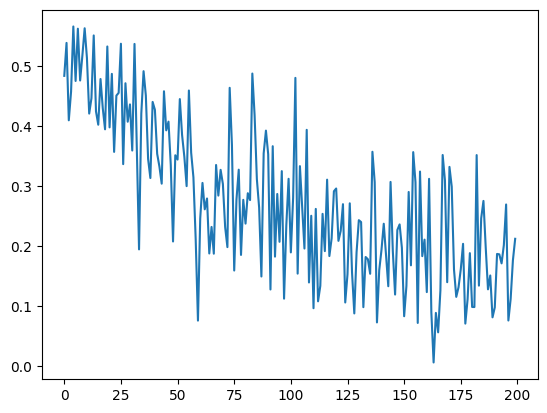

In [13]:
### TODO remove this chart after testing
from matplotlib import pyplot as plt
plt.plot(losses)

## Why use two towers instead of content or collaborative filtering?
This seems rather complicated compared to other recommender system architectures, so why go through with all of this effort? The best way to answer this is to compare with other recommendation system approaches.

### Shortcomings of content filtering
The simplest machine learning approach to recommendations is content filtering. It's also an approach that doesn't take into account user behaviors beyond finding similar content. This may not sound too bad, but can quickly lead to users getting trapped into content bubbles, where once they interact with a certain item - even if it was just randomly - they only see similar items.

### Shortcomings of collaborative filtering
Collaborative filtering approaches like Singular Value Decomposition (SVD) take the opposite approach and _only_ consider user behaviors to make recommendations. This has clear advantages, but one major drawback; SVD can't handle brand new users or brand new content. Each time a new user joins, or a new content is added to your library they won't have associated vectors. There also won't be meaningful new interaction data to re-train a model and generate vectors. It can be bad enough that a model needs frequent re-training; it can be an even bigger issue if you can't make recommendations for new users and content.

Two tower models overcome these obstacles and to better understand how let's dive into what this type of architectures is really doing.

## Two Towers Separate Embedding Vector Creation from Model Training
Now that we have a trained model we can use each tower in our two tower model to generate embeddings for our users and items.
Unlike SVD, we don't have to retrain our model to get these vectors. We also don't need new interaction data for our users or content.

In [14]:
user_embeddings = model.get_user_embeddings(user_features=torch.tensor(users_df['feature_vector'].tolist(), dtype=torch.float32))
restaurant_embeddings = model.get_restaurant_embeddings(restaurant_features=torch.tensor(df['feature_vector'].tolist(), dtype=torch.float32))

## The Best of Both Worlds
Two tower models are a triple whammy when it comes to solving the above problems:
- They are trained on interaction data, aka our labels, so learn not to fall into content bubbles
- They directly consider the user features _and_ content features
- they can handle brand new users and content that don't yet have interaction data. No retraining necessary

While we need some interaction data to train our model initially, it's totally fine if not all users or restaurants are included in our labelled data. Only a sample is needed.
This is why we can handle new users and content without retraining. Only their raw features are needed to generate embeddings


## Loading into Redis
With two sets of vectors we'll load the restaurant data into a Redis vector store to search over, and the user vectors into a regular key look up for quick access.
We'll handle our restaurants opening and closing hours, as well as their location in longitude and latitude. We'll want these for later.

In [15]:
#  extract opening and closing times from the 'hours' column
def extract_opening_closing_times(hours, day):
    # convert to a simple numeric representation of times
    if day in hours:
        return int(hours[day][0][0].replace(':','')), int(hours[day][0][1].replace(':',''))
    else:
        # we don't know their hours, assume a reasonable default of 9:00am to 8:00pm
        return 900, 2000

# create new columns for opening and closing times for each day of the week
for day in ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']:
    df[f'{day}_open'], df[f'{day}_close'] = zip(*df['hours'].apply(lambda x: extract_opening_closing_times(x, day)))

# combine 'longitude' and 'latitude' into a single 'location' column
df['location'] = df.apply(lambda row: f"{row['longitude']},{row['latitude']}", axis=1)

# drop the original 'hours' separate 'latitude' and 'longitude' columns as we don't need them anymore
df.drop(columns=['hours', 'latitude', 'longitude'], inplace=True)

# ensure the 'embedding' column is in the correct format (list of floats)
df['embedding'] = restaurant_embeddings.detach().numpy().tolist()

# ensure all columns are in the correct order as defined in the schema
df = df[['name', 'address', 'locality', 'location', 'cuisine', 'price', 'rating', 'sunday_open', 'sunday_close', 'monday_open', 'monday_close', 'tuesday_open', 'tuesday_close', 'wednesday_open', 'wednesday_close', 'thursday_open', 'thursday_close', 'friday_open', 'friday_close', 'saturday_open', 'saturday_close', 'embedding']]

# print the first record to verify the format
print(df.to_dict(orient='records')[0])

{'name': '21st Amendment Brewery & Restaurant', 'address': '563 2nd St', 'locality': 'San Francisco', 'location': '-122.392576,37.782448', 'cuisine': ['Cafe', 'Pub Food', 'American', 'Burgers', 'Pizza'], 'price': 2, 'rating': 4.0, 'sunday_open': 1000, 'sunday_close': 2359, 'monday_open': 1130, 'monday_close': 2359, 'tuesday_open': 1130, 'tuesday_close': 2359, 'wednesday_open': 1130, 'wednesday_close': 2359, 'thursday_open': 1130, 'thursday_close': 2359, 'friday_open': 1130, 'friday_close': 2359, 'saturday_open': 1130, 'saturday_close': 2359, 'embedding': [-0.10858028382062912, 0.08144018799066544, -0.09743182361125946, 0.12570498883724213, 0.0667014941573143, 0.09980754554271698, 0.10615932941436768, -0.052137602120637894, 0.12902617454528809, 0.07643865793943405, -0.05024845898151398, 0.08054398745298386, -0.13104072213172913, 0.012574836611747742, 0.13008467853069305, -0.020445453003048897, -0.04451757296919823, 0.013301768340170383, -0.0338381789624691, -0.0017678269650787115, 0.151

In [16]:
from redis import Redis
from redisvl.schema import IndexSchema
from redisvl.index import SearchIndex

client = Redis.from_url(REDIS_URL)

restaurant_schema = IndexSchema.from_dict({
    'index': {
        'name': 'restaurants',
        'prefix': 'restaurant',
        'storage_type': 'json'
    },
    'fields': [
        {'name': 'name', 'type': 'text'},
        {'name': 'address', 'type': 'text'},
        {'name': 'locality', 'type': 'tag'},
        {'name': 'location', 'type': 'geo'},
        {'name': 'cuisine', 'type': 'tag'},
        {'name': 'price', 'type': 'numeric'},
        {'name': 'rating', 'type': 'numeric'},
        {'name': 'sunday_open', 'type': 'numeric'},
        {'name': 'sunday_close', 'type': 'numeric'},
        {'name': 'monday_open', 'type': 'numeric'},
        {'name': 'monday_close', 'type': 'numeric'},
        {'name': 'tuesday_open', 'type': 'numeric'},
        {'name': 'tuesday_close', 'type': 'numeric'},
        {'name': 'wednesday_open', 'type': 'numeric'},
        {'name': 'wednesday_close', 'type': 'numeric'},
        {'name': 'thursday_open', 'type': 'numeric'},
        {'name': 'thursday_close', 'type': 'numeric'},
        {'name': 'friday_open', 'type': 'numeric'},
        {'name': 'friday_close', 'type': 'numeric'},
        {'name': 'saturday_open', 'type': 'numeric'},
        {'name': 'saturday_close', 'type': 'numeric'},
        {
            'name': 'embedding',
            'type': 'vector',
            'attrs': {
                'dims': 128,
                'algorithm': 'flat',
                'datatype': 'float32',
                'distance_metric': 'cosine'
            }
        }
    ]
})

restaurant_index = SearchIndex(restaurant_schema, redis_client=client)
restaurant_index.create(overwrite=True, drop=True)

restaurant_keys = restaurant_index.load(df.to_dict(orient='records'))

16:16:30 redisvl.index.index INFO   Index already exists, overwriting.


In [17]:
# load the user vectors into a regular redis space
from redis.commands.json.path import Path

with client.pipeline() as pipe:
    for user_id, embedding in zip(users_df['user_id'], user_embeddings):
        user_key = f"user:{user_id}"

        user_data = {
            "user_embedding": embedding.tolist(),
        }
        pipe.json().set(user_key, Path.root_path(), user_data)
    pipe.execute()

## The power of deep learning with the speed of Redis

I can hear you say it, "deep learning is cool and all, but I need my system to be fast. I don't want to call a deep neural network to get recommendations."

Well not to fear my friend, you won't have to! While training our model may take a while, you won't need to do this often.
And if you look closely you'll see that both the user and content embedding vectors can be generated once and reused again and again.
Only the vector search is happening when generating recommendations.
These embeddings will only change if your user or content features change and if you select your features wisely this won't be often.

## Location Aware Recommendations

We've shown how Redis can apply filters on top of vector similarity search to further refine results, but did you know it can also refine search results by location?
Using the `Geo` field type on our index definition we can apply a `GeoRadius` filter to find only places nearby, which seems mighty useful for a restaurant recommendation system.

Combining `GeoRadius` with `Num` tags we can find places that are personally relevant to us, nearby _and_ open for business right now.

We have all our data and vectors ready to go. Now let's put it all together with query logic.

In [18]:
from redisvl.query.filter import Tag, Num, Geo, GeoRadius
import datetime

def get_filter(user_long,
               user_lat,
               current_date_time,
               radius=1000,
               low_price=0.0,
               high_price=5.0,
               rating=0.0,
               cuisines=[]):

    geo_filter = Geo("location") == GeoRadius(user_long, user_lat, radius, unit="m") # use a distance unit of meters

    open_filter = Num(f"{current_date_time.strftime('%A').lower()}_open") < current_date_time.hour*100 + current_date_time.minute
    close_filter = Num(f"{current_date_time.strftime('%A').lower()}_close") > current_date_time.hour*100 + current_date_time.minute
    time_filter = open_filter & close_filter

    price_filter = (Num('price') >= low_price) & (Num('price') <= high_price)

    rating_filter = Num('rating') >= rating

    cuisine_filter = Tag('cuisine') == cuisines

    return geo_filter & time_filter & price_filter & rating_filter & cuisine_filter


In [19]:
from redisvl.query import VectorQuery

random_user = random.choice(users_df['user_id'].tolist())
user_vector = client.json().get(f"user:{random_user}")["user_embedding"]

# get a location for this user. Your app may call an API, here we'll set one randomly to within San Francisco
# San Francisco is within the longitude and latitude bounding box of:
# Lower corner: (-122.5137, 37.7099) in (longitude, latitude) format
# Upper corner: (-122.3785, 37.8101)

longitude = random.uniform(-122.5137, -122.3785)
latitude = random.uniform(37.7099, 37.8101)
radius = 2000

full_filter = get_filter(user_long=longitude,
                         user_lat=latitude,
                         radius=radius,
                         current_date_time=datetime.datetime.today())

query = VectorQuery(vector=user_vector,
                    vector_field_name='embedding',
                    num_results=10,
                    return_score=False,
                    return_fields=['name', 'address', 'location', 'distance'],
                    filter_expression=full_filter,
                    )

results = restaurant_index.query(query)
print(f"found {len(results)} results from our query")
for r in results:
    print(r)

found 6 results from our query
{'id': 'restaurant:e4d1f442ec2e470c88ff8d66f5232af0', 'name': "Rose's Cafe", 'address': '2298 Union St', 'location': '-122.437027,37.797011'}
{'id': 'restaurant:07d2a411795645cfa33453e17dbf02f2', 'name': 'Presidio Social Club', 'address': '563 Ruger St', 'location': '-122.448199,37.797274'}
{'id': 'restaurant:c12a9c8c6c404fbf8baed3092574d420', 'name': 'Squat & Gobble Cafe', 'address': '2263 Chestnut St', 'location': '-122.440531,37.800168'}
{'id': 'restaurant:45ff166c908f4855bd8a4616f682c697', 'name': 'Pizzeria Delfina', 'address': '2406 California St', 'location': '-122.434241,37.788925'}
{'id': 'restaurant:71467e1524e544c19f3f57e6eb6da112', 'name': 'La Boulange', 'address': '2043 Fillmore St', 'location': '-122.43386,37.788408'}
{'id': 'restaurant:21a47ecfa7e5478eb75c29d9b2b5eb4a', 'name': "Perry's", 'address': '1944 Union St', 'location': '-122.431267,37.797787'}


## Seeing Is Believing

With our vectors loaded and helper functions defined we can get some nearby recommendations. That's all well and good, but don't you wish you could see these recommendations? I sure do. So let's visualize them on an interactive map.

In [20]:
#NBEVAL_SKIP
!pip install folium clipboard --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [21]:
import folium
import clipboard
from IPython.display import display

# create a map centered around San Francisco
figure = folium.Figure(width=700, height=600)
sf_map = folium.Map(location=[37.7749, -122.4194],
               zoom_start=13,
               max_bounds=True,
                min_lat= 37.709 - 0.1,
                max_lat= 37.8101 + 0.1,
                min_lon= -122.3785 - 0.3,
                max_lon= -122.5137 + 0.3,
    )

sf_map.add_to(figure)

# add markers for each restaurant in blue
for idx, row in df.iterrows():
    lat, lon = map(float, row['location'].split(','))
    folium.Marker([lon, lat], popup=row['name']).add_to(sf_map)


# get personalized recommendations
user = users_df['user_id'].tolist()[42]
user_vector = client.json().get(f"user:{user}")["user_embedding"]

# get a location for this user. Your app may call an API, here we'll set one randomly to within San Francisco
# lower corner: (-122.5137, 37.7099) in (longitude, latitude) format
# upper corner: (-122.3785, 37.8101)

longitude, latitude = -122.439, 37.779
num_results = 25
radius = 2000

# draw a circle centered on our user
folium.Circle(
    location=[latitude, longitude],
    radius=radius,
    color="green",
    weight=3,
    fill=True,
    fill_opacity=0.3,
    opacity=1,
).add_to(sf_map)


full_filter = get_filter(user_long=longitude,
                         user_lat=latitude,
                         radius=radius,
                         current_date_time=datetime.datetime.today()
                         )

query = VectorQuery(vector=user_vector,
                    vector_field_name='embedding',
                    num_results=num_results,
                    return_score=False,
                    return_fields=['name', 'address', 'location', 'rating'],
                    filter_expression=full_filter,
                    )

results = restaurant_index.query(query)

# now show our recommended places in red
for restaurant in results:
    lat, lon = map(float, restaurant['location'].split(','))
    folium.Marker([lon, lat], popup=restaurant['name'] + ' ' + restaurant['rating'] + ' stars', icon=folium.Icon(color='red')).add_to(sf_map)

display(sf_map)


## Conclusion
That's it! You've built a deep learning recommendation system with Redis. It's personalized, location aware, adaptable, and fast.

In [22]:
# clean up your index
while remaining := restaurant_index.clear():
    print(f"Deleted {remaining} keys")

client.delete(*[f"user:{user_id}" for user_id in users_df['user_id'].tolist()])

Deleted 147 keys


1000